Trabajo fin de máster:  
#### SISTEMA DE PREDIAGNÓSTICO DE NEUMONÍA MEDIANTE INTELIGENCIA ARTIFICIAL
Autor: **José María de Cuenca**

Cuaderno: **9 - Ejecutable final**


In [1]:
### ##########################################################
### DIAGNOSTICO DE PNEUMONIA CON RADIOGRAFIAS
### Jose Maria de Cuenca
### ##########################################################

%matplotlib inline

## Importo librerias y cargo funciones
# Generales, acceso y exploración de archivos
import os
import numpy as np
import pandas as pd
from PIL import Image

# Graficos
import matplotlib.pyplot as plt

# Carga de conjuntos de datos
import cv2
from skimage.io import imread
from skimage.transform import resize

# Transferencia de aprendizaje para modelos clasicos
from sklearn.externals import joblib

# Transferencia de aprendizaje para modelos de aprendizaje profundo
from keras.models import load_model
from keras.models import model_from_json
import json


Using TensorFlow backend.


**Modelos clásicos**

Se utilizan los modelos clásicos de clasificación creados: SVM, aplicado a 2 y a 3 clases.

Previamente adapto el formato de las imágenes cargadas en los conjuntos a las dimensiones que requiere. También realizo la transformación PCA con el modelo de componentes principales (PCA) previamente creado.  

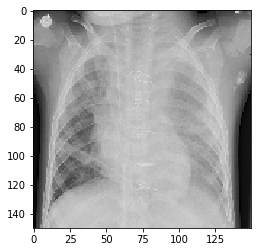

In [2]:
## Carga de imagen a predecir

# Carga la imagen
img = cv2.imread('./data/chest_xray/train/pneumonia/person3_bacteria_10.jpeg')

img = cv2.resize(img, (150, 150))

if img.shape[2] ==1:
    img = np.dstack([img, img, img])

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Cambio del formato de entrada (orden BGR de OpenCV) al estandar (orden RGB)
img = img.astype(np.float32)/255.0 # aprovecho para normalizar los datos. Se corresponde a la escala del espacio de color

img_array = np.asarray(img)

plt.imshow(img_array )

In [3]:
## PREPARACION FORMATO IMAGEN PARA MODELO SVM

#Formato de imagen de carga
print("Formato imagen de carga")
print(img_array.shape)

# Aseguro las dimensiones del array como imagenes de entrada para el modelo SVM
X_train2_svm=img_array.reshape(1,67500)

# Compruebo
print("Formato imagenes para entrada del modelo")
print(X_train2_svm.shape)


Formato imagen de carga
(150, 150, 3)
Formato imagenes para entrada del modelo
(1, 67500)


In [4]:
# #############################################################################
## ANALISIS DE COMPONENTES PRINCIPALES PCA PARA 2 CLASES

# Cargo extractor de componentes principales para la imagen
pca2 = joblib.load('./data/chest_xray/pca2.pkl')


# Proyeccion para 2 clases
print("\nProyectando los datos de entrada sobre la base ortonormal de los eigenfaces")
X_train2_pca = pca2.transform(X_train2_svm)
print(X_train2_pca.shape)

# #############################################################################
# Cargo el clasificador SVM para 2 clases
clf2 = joblib.load('./data/chest_xray/clf2.pkl')

# Uso el modelo para predecir el diagnostico en el conjunto de prueba tras PCA
y_pred2 = clf2.predict(X_train2_pca)

# Informe de prediccion con este modelo
print("\nPrediccion con SVM 2 clases:", y_pred2)



Proyectando los datos de entrada sobre la base ortonormal de los eigenfaces
(1, 150)

Prediccion con SVM 2 clases: ['1']


In [5]:
# #############################################################################
## ANALISIS DE COMPONENTES PRINCIPALES PCA PARA 3 CLASES

# Cargo extractor de componentes principales para la imagen
pca3 = joblib.load('./data/chest_xray/pca3.pkl')


# Proyeccion para 2 clases
print("\nProyectando los datos de entrada sobre la base ortonormal de los eigenfaces")
X_train3_pca = pca3.transform(X_train2_svm)
print(X_train3_pca.shape)

# #############################################################################
# Cargo el clasificador SVM para 2 clases
clf3 = joblib.load('./data/chest_xray/clf3.pkl')

# Uso el modelo para predecir el diagnostico en el conjunto de prueba tras PCA
y_pred3 = clf3.predict(X_train3_pca)

# Informe de prediccion con este modelo
print("\nPrediccion con SVM 3 clases:", y_pred3)



Proyectando los datos de entrada sobre la base ortonormal de los eigenfaces
(1, 150)

Prediccion con SVM 3 clases: ['2']


**Modelos de aprendizaje profundo**

Utilizo los modelos de redes convolucionales separables para 2 y 3 clases, con los pesos de entrenamiento guardados.


In [6]:
#############################################################################
## PREPARACION CONJUNTO DE DATOS PARA MODELOS DE REDES NEURONALES CONVOLUCIONADAS

# PARA 2 CLASES

#Formato de imagenes en los conjuntos de carga
print("Formato imagenes en conjuntos de carga 2 clases")
print(img_array.shape)

# Aseguro las dimensiones del array como imagenes de entrada para el modelo
X_train2=img_array.reshape(1,3,150,150)

# Compruebo
print("Formato imagenes para entrada del modelo 2 clases")
print(X_train2.shape)


Formato imagenes en conjuntos de carga 2 clases
(150, 150, 3)
Formato imagenes para entrada del modelo 2 clases
(1, 3, 150, 150)


In [7]:
## CARGO MODELO ENTRENADO DE 2 CLASES

with open('./data/chest_xray/model_basico2.json','r') as f:
    json_string = f.read()

model_basico2 = model_from_json(json_string)
model_basico2.load_weights('./data/chest_xray/model_basico2.h5')


# Carlo modelo con sus pesos
# model_basico2 = load_model('./data/chest_xray/model_basico2.h5')

# Resumen del modelo
print(model_basico2.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 150, 150)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 75, 75)        0         
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 64, 75, 75)        4736      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 37, 37)        0         
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 64, 37, 37)        4736      
_________________________________________________________________
batch_normalization_3

In [8]:
# ##########################################
# Uso el modelo para predecir el diagnostico
print(model_basico2.predict(X_train2))
y_mod_bas_2 = np.round_((model_basico2.predict(X_train2)[:,1]), decimals=0).astype(int)

# Informe de prediccion con este modelo
print("\nPrediccion con modelo basico 2 clases:", y_mod_bas_2)


[[0.00984949 0.9901506 ]]

Prediccion con modelo basico 2 clases: [1]


In [9]:
## CARGO MODELO ENTRENADO DE 3 CLASES

with open('./data/chest_xray/model_basico3.json','r') as f:
    json_string = f.read()

model_basico3 = model_from_json(json_string)
model_basico3.load_weights('./data/chest_xray/model_basico3.h5')


# Carlo modelo con sus pesos
# model_basico2 = load_model('./data/chest_xray/model_basico2.h5')

# Resumen del modelo
print(model_basico3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 150, 150)      1792      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 75, 75)        0         
_________________________________________________________________
separable_conv2d_10 (Separab (None, 64, 75, 75)        4736      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 37, 37)        0         
_________________________________________________________________
separable_conv2d_11 (Separab (None, 64, 37, 37)        4736      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 37, 37)        148       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 18, 18)        0         
__________

In [10]:
# ##########################################
# Uso el modelo para predecir el diagnostico 
print(model_basico3.predict(X_train2))

y_mod_bas_3 = np.argmax(model_basico3.predict(X_train2), axis=1)

# Informe de prediccion con este modelo
print("\nPrediccion con modelo basico 3 clases:", y_mod_bas_3)


[[0.00381924 0.70161563 0.2945651 ]]

Prediccion con modelo basico 3 clases: [1]


**Ensemble de modelos**

Realizo el mismo ensemble manual de los modelos seleccionados que el realizado en la creación del algoritmo, mediante asignaciónde pesos a la predicción de cada modelo. 

In [11]:
### ENSEMBLE MANUAL TIPO VOTING para 2 clases (no se puede automatizar por diferente formato de los datos)

# Analisis por filas
val0_fila = 0
val1_fila = 0

# SVM2
peso = 1
if y_pred2 == 0:
    val0_fila = val0_fila + peso
else:
    val1_fila = val1_fila + peso
        
# SVM3
peso = 2
if y_pred3 == 0:
    val0_fila = val0_fila + peso
else:
    val1_fila = val1_fila + peso

# ConvSep2
peso = 3
if y_mod_bas_2 == 0:
    val0_fila = val0_fila + peso
else:
    val1_fila = val1_fila + peso
    
# ConvSep3
peso = 2
if y_mod_bas_3 == 0:
    val0_fila = val0_fila + peso
else:
    val1_fila = val1_fila + peso


# Balance para poner el valor dominante en la lista de resultados
if val0_fila > val1_fila:
    voting_2=0
else:
    voting_2=1

print ('\nPredicción de 2 clases con ensemble: ', voting_2)



Predicción de 2 clases con ensemble:  1


C:\Users\jmcuencac.AQUAVALL\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':
C:\Users\jmcuencac.AQUAVALL\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()


In [12]:
### ENSEMBLE MANUAL TIPO VOTING para 3 clases (no se puede automatizar por diferente formato de los datos)

# Analisis por filas
val0_fila = 0
val1_fila = 0
val2_fila = 0

# SVM2
peso = 3
if y_pred2 == 0:
    val0_fila = val0_fila + peso
else:
    val1_fila = val1_fila + peso
        
# SVM3
peso = 2
if y_pred3 == 0:
    val0_fila = val0_fila + peso
elif y_pred3 == 1:
    val1_fila = val1_fila + peso
else:
    val2_fila = val2_fila + peso

# ConvSep2
peso = 3
if y_mod_bas_2 == 0:
    val0_fila = val0_fila + peso
else:
    val1_fila = val1_fila + peso
    
# ConvSep3
peso = 2
if y_mod_bas_3 == 0:
    val0_fila = val0_fila + peso
elif y_mod_bas_3 == 1:
    val1_fila = val1_fila + peso
else:
    val2_fila = val2_fila + peso


# Balance para poner el valor dominante en la lista de resultados
if val0_fila > val1_fila and val0_fila > val2_fila:
    voting_3 = 0
elif val1_fila > val2_fila:
    voting_3 = 1
else:
    voting_3 = 2


print ('\nPredicción de 3 clases con ensemble: ', voting_2)


Predicción de 3 clases con ensemble:  1


C:\Users\jmcuencac.AQUAVALL\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.
C:\Users\jmcuencac.AQUAVALL\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\jmcuencac.AQUAVALL\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
